<a href="https://colab.research.google.com/github/wsilveira-splunk/channel_capacity/blob/master/channel_capacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

In [16]:
snr_db = list(range(-8, 31, 1))
snr = list(map(lambda x: pow(10, (x/10)), snr_db))
C_gaussian_ch = list(map(lambda x: 0.5*math.log2(1+x), snr))

#C_bsc = 

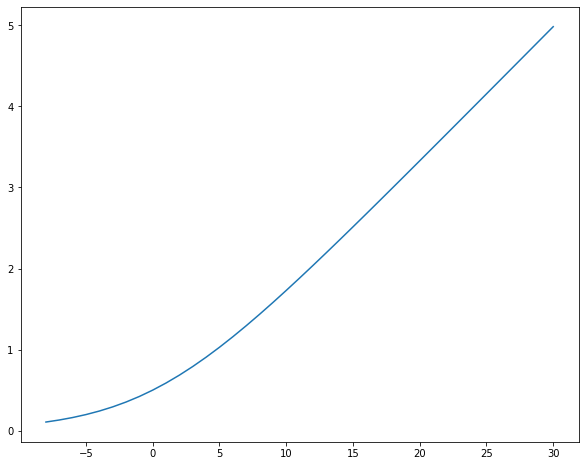

In [17]:
plt.figure(figsize=(10,8)) 
plt.plot(snr_db, C_gaussian_ch) 
plt.show()